## This notebook starts from existing azimuth and altitude maps of mouse visual cortex and calculates the visual sign map and segments the sign map into several patches (putative visual areas). 

<br><br>

Currently the [retinotopic_mapping package](https://github.com/zhuangjun1981/retinotopic_mapping) does not include the analysis code which generates altitude and azimuth maps from raw acquired image series and visual stimulation log. This is because 
the various hardware and software people use to display visual stimuli and to acquire images. There is no universal way to preprocess data.

<br><br>

The procedures used in [Zhuang et al., 2017](https://elifesciences.org/articles/18372) to generate altitude and azimuth maps are as follows:

1.	For stimulus sweep in each direction (bottom-up, top-down, nasal-temporal and temporal-nasal), the raw acquired movies were averaged across all presentations. It generated four averaged movies for each sweep direction. The duration of each movie equals the duration of one cycle of corresponding sweep (one sweep across the screen plus inter-sweep gray period). 
2.	For each averaged movie, the mean activity over the pre-sweep gray period was subtracted to generate delta F movies. Delta F movies should look like video 1 in Zhuang et al., 2017, Elife, 6:e18372. There will be four delta F movies, each corresponding to one sweep direction.
3.	Perform fft of each delta F movie along the time dimension and extract the phase of the first harmonic frequency component. Because these are averaged movies, the first harmonic frequency should be the frequency of the visual stimulus sweep. There will be four different phase maps, each corresponding to one sweep direction. Power maps at this particular frequency can be also extracted at this step.
4.	The phase represents the timing within the cycle, by analyzing the visual stimulus log (this part depends on how visual stimulus was displayed which may vary significantly from lab to lab), the phase can be converted to the location of the sweeping checkerboard on screen. After the conversion, four location maps will be generated, each corresponding to a sweep direction.
5.	The location maps of bottom-up and top-down directions were averaged to generate the altitude map, and location maps of nasal-temporal and temporal-nasal directions were averaged to generate the azimuth map.  

<br><br>
In python the code of phase and power extracting looks like these (assuming the first dimension of the movie is time):  
<br><br>
```
import numpy as np

spectrumMovie = np.fft.fft(movie, axis=0)

#generate power movie
powerMovie = (np.abs(spectrumMovie) * 2.) / np.size(movie, 0)
powerMap = np.abs(powerMovie[1,:,:])

#generate phase movie
phaseMovie = np.angle(spectrumMovie)
phaseMap = -1 * phaseMovie[1,:,:]
phaseMap = phaseMap % (2 * np.pi)
```

In [1]:
import os
import glob
import cv2
import re

import numpy as np
import scipy.stats as spstats

import retinotopic_mapping
import retinotopic_mapping.tools.FileTools as ft
import retinotopic_mapping.tools.PlottingTools as pt

import retinotopic_mapping.RetinotopicMapping as rm
import skimage.external.tifffile as tf
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
import cv2
from scipy import misc,interpolate,stats,signal
from matplotlib.colors import LinearSegmentedColormap


def smooth_array(inputArray, fwhm, phaseArray=False):
    szList=np.array([None,None,None,11,None,21,None,27,None,31,None,37,None,43,None,49,None,53,None,59,None,55,None,69,None,79,None,89,None,99])
    sigmaList=np.array([None,None,None,.9,None,1.7,None,2.6,None,3.4,None,4.3,None,5.1,None,6.4,None,6.8,None,7.6,None,8.5,None,9.4,None,10.3,None,11.2,None,12])
    sigma=sigmaList[fwhm]
    sz=szList[fwhm]
    #print(sigma, sz)
    if phaseArray:
        outputArray = smooth_phase_array(inputArray,sigma,sz)
    else:
        outputArray=cv2.GaussianBlur(inputArray, (sz,sz), sigma, sigma)
        
    return outputArray
        
def smooth_phase_array(theta,sigma,sz):
    #build 2D Gaussian Kernel
    kernelX = cv2.getGaussianKernel(sz, sigma); 
    kernelY = cv2.getGaussianKernel(sz, sigma); 
    kernelXY = kernelX * kernelY.transpose(); 
    kernelXY_norm=np.true_divide(kernelXY,np.max(kernelXY.flatten()))
    
    #get x and y components of unit-length vector
    componentX=np.cos(theta)
    componentY=np.sin(theta)
    
    #convolce
    componentX_smooth=signal.convolve2d(componentX,kernelXY_norm,mode='same',boundary='symm')
    componentY_smooth=signal.convolve2d(componentY,kernelXY_norm,mode='same',boundary='symm')

    theta_smooth=np.arctan2(componentY_smooth,componentX_smooth)
    return theta_smooth


def shift_map(phase_az):
    phaseC_az=np.copy(phase_az)
    minv = phase_az[~np.isnan(phase_az)].min()
    maxv = phase_az[~np.isnan(phase_az)].max()
    #print(minv, maxv)
    if (minv < 0): # and maxv > 0):
        phaseC_az[phase_az<0]=-phase_az[phase_az<0]
        #print("flipped neg", phaseC_az.min(), phaseC_az.max())
        phaseC_az[phase_az>0]=(2*np.pi)-phase_az[phase_az>0]
        #print("flipped pos", phaseC_az.min(), phaseC_az.max())

    else:
        print("Already non-negative (min/max: %.2f, %.2f)" % (phaseC_az.min(), phaseC_az.max()))
    return phaseC_az


In [3]:
def label_figure(fig, data_id):
    fig.text(0, .97, data_id)


In [4]:

def convert_range(oldval, newmin=None, newmax=None, oldmax=None, oldmin=None):
    oldrange = (oldmax - oldmin)
    newrange = (newmax - newmin)
    newval = (((oldval - oldmin) * newrange) / oldrange) + newmin
    return newval

In [5]:
# move to package example folder 

package_folder = retinotopic_mapping.__path__
example_folder = os.path.join(package_folder[0], 'examples', 'signmap_analysis')
os.chdir(example_folder)

# Reading example vasculature image

In [11]:
# Base dirs
rootdir = '/n/coxfs01/2p-data'
# surface_basedir = '/n/coxfs01/widefield-data/analyzed_data/Retinotopy/phase_encoding/Images_Cartesian_Constant'
analysis_basedir = '/n/coxfs01/widefield-data/analyzed_data/Retinotopy/phase_encoding/Images_Cartesian_Constant'
analysis_subdirs = 'Analyses/timecourse/not_motion_corrected/excludeEdges_averageFrames_11_minusRollingMean'


In [492]:
# animalid = 'JC085'

animalid = 'JC061' #'JC113' #'JC076'

# find sessions
found_sessions = np.unique([os.path.split(sesh)[-1].split('_')[0] \
                  for sesh in glob.glob(os.path.join(analysis_basedir, animalid, '2019*'))])
print('[%s]: Found %i sessions' % (animalid, len(found_sessions)))
for si, sesh in enumerate(found_sessions):
    print(si, sesh)
    

sesh = found_sessions[-1]
print(sesh)
surface_path = glob.glob(os.path.join(analysis_basedir, animalid, '%s*' % sesh, 'Surface', '*.png'))[0]
session = os.path.split(surface_path.split('/Surface')[0])[-1].split('_')[0]
data_id = '%s_%s' % (animalid, session)
print("DATA ID: %s" % data_id)

[JC061]: Found 1 sessions
(0, '20190306')
20190306
DATA ID: JC061_20190306


# Get vasculature image

In [493]:
#surface_path = glob.glob(os.path.join(analysis_basedir, animalid, session, 'Surface', '*.png'))[0]
surface_path = glob.glob(os.path.join(rootdir, animalid, 'macro_maps', '20*', '*urf*.png'))[0]

vasculature_map = cv2.imread(surface_path, -1)
widefield_d1, widefield_d2 = vasculature_map.shape
print("Surface image (%i, %i | %s)" % (widefield_d1, widefield_d2, vasculature_map.dtype))

Surface image (492, 656 | uint16)


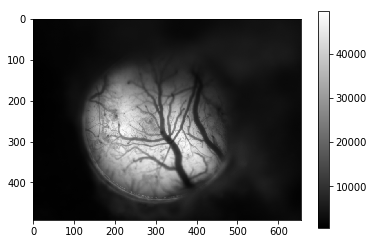

In [494]:
#vasculature_map = tf.imread('example_vasculature_map.tif')
#vasculature_map = cv2.imread(surface_path, -1)
_ = plt.imshow(vasculature_map, cmap='gray', interpolation='nearest')
_ = plt.colorbar()
plt.show()

# Reading example retinotopic maps
cond1 = left
cond2 = right
cond3 = top
cond4 = bottom

In [495]:
mappaths = glob.glob(os.path.join(analysis_basedir, animalid, '%s*' % session, analysis_subdirs, 'phase_decoding', 'Files', '*.npz'))
for i, p in enumerate(mappaths):
    print(i, p)

condition_nums = {1: 'left',
                  2: 'right',
                  3: 'top',
                  4: 'bottom'}

condition_keys = {'azimuth': ['left', 'right'],
                  'altitude': ['top', 'bottom']}

mappath_d = {}
for mpath in mappaths:

    cond_name = re.findall(r'cond\d{1}_maps', mpath)[0]
    cond_num = int(re.findall(r'\d{1}', cond_name)[0])
    curr_cond = condition_nums[cond_num]
    
    mappath_d.update({curr_cond: mpath})


(0, '/n/coxfs01/widefield-data/analyzed_data/Retinotopy/phase_encoding/Images_Cartesian_Constant/JC061/20190306/Analyses/timecourse/not_motion_corrected/excludeEdges_averageFrames_11_minusRollingMean/phase_decoding/Files/20190306_cond2_maps.npz')
(1, '/n/coxfs01/widefield-data/analyzed_data/Retinotopy/phase_encoding/Images_Cartesian_Constant/JC061/20190306/Analyses/timecourse/not_motion_corrected/excludeEdges_averageFrames_11_minusRollingMean/phase_decoding/Files/20190306_cond3_maps.npz')


In [496]:
mappath_d

{'right': '/n/coxfs01/widefield-data/analyzed_data/Retinotopy/phase_encoding/Images_Cartesian_Constant/JC061/20190306/Analyses/timecourse/not_motion_corrected/excludeEdges_averageFrames_11_minusRollingMean/phase_decoding/Files/20190306_cond2_maps.npz',
 'top': '/n/coxfs01/widefield-data/analyzed_data/Retinotopy/phase_encoding/Images_Cartesian_Constant/JC061/20190306/Analyses/timecourse/not_motion_corrected/excludeEdges_averageFrames_11_minusRollingMean/phase_decoding/Files/20190306_cond3_maps.npz'}

In [497]:
def convert_to_absolute(cond_data, smooth_fwhm=7, smooth=True, power_metric='mag'):
    '''combine absolute, or shift single-cond map so that
    
    if AZI, 0=left, 2*np.pi=right 
    if ALT, 0=bottom 2*np.pi= top
    
    Use this to convert to linear coords, centered around 0.
    
    power_metric: can be 'mag' or 'magRatio' (for Map type saved in analyzed maps).
    
    '''
    vmin = 0
    vmax = 2*np.pi

    if len(cond_data.keys()) > 1:
        c1 = 'left' if 'left' in cond_data.keys() else 'top'
        c2 = 'right' if c1=='left' else 'bottom'
    
        # Phase maps
        if smooth:
            m1 = shift_map(smooth_array(cond_data[c1]['phaseMap'], smooth_fwhm, phaseArray=True))
            m2 = shift_map(smooth_array(cond_data[c2]['phaseMap'], smooth_fwhm, phaseArray=True))
        else:
            m1 = shift_map(cond_data[c1]['phaseMap'])
            m2 = shift_map(cond_data[c2]['phaseMap'])
            
        combined_phase_map = spstats.circmean(np.dstack([m1, m2]), axis=-1, low=vmin, high=vmax) 
        
        # Mag maps
        p1 = cond_data[c1]['%sMap' % power_metric]
        p2 = cond_data[c2]['%sMap' % power_metric]
        combined_mag_map = np.mean(np.dstack([p1, p2]), axis=-1)

    else:
        if 'right' in cond_data.keys() and 'top' not in cond_data.keys():
            m1 = cond_data['right']['phaseMap'].copy()
            m2 = cond_data['right']['phaseMap'].copy()*-1
            p1 = cond_data['right']['%sMap' % power_metric].copy()
            
        elif 'top' in cond_data.keys() and 'right' not in cond_data.keys():
            m1 = cond_data['top']['phaseMap'].copy()
            m2 = cond_data['top']['phaseMap'].copy()*-1
            p1 = cond_data['top']['%sMap' % power_metric].copy()
        
        # Phase maps
        combined_phase_map = (m2-m1)/2.
        
        # Mag maps
        combined_mag_map = p1
        
        if smooth:
            combined_phase_map = smooth_array(combined_phase_map, smooth_fwhm, phaseArray=True)
            combined_mag_map = smooth_array(combined_mag_map, smooth_fwhm, phaseArray=False)
        
        # Shift maps
        combined_phase_map = shift_map(combined_phase_map) # values should go from 0 to 2*pi        
    
    return combined_phase_map, combined_mag_map #_shift

In [498]:
# shift = True
# cmap = 'nipy_spectral'

# condition_keys = {'azimuth': ['left', 'right'],
#                   'altitude': ['top', 'bottom']}

    
# mapdata_az = np.load(mappaths[1]) if len(mappaths)==4 else np.load(mappaths[0]) 
# mapdata_el = np.load(mappaths[2]) if len(mappaths)==4 else np.load(mappaths[1]) 

# if shift:
#     altitude_map = shift_map(mapdata_el['phaseMap'].copy())
#     azimuth_map = shift_map(mapdata_az['phaseMap'].copy())
# else:
#     altitude_map = mapdata_el['phaseMap']
#     azimuth_map = mapdata_az['phaseMap']


In [499]:
shift = True
cmap = 'nipy_spectral'
smooth_fwhm = 7
smooth_first = True

vmin = 0 if shift else -np.pi
vmax = 2*np.pi if shift else np.pi

condition_keys = {'azimuth': ['left', 'right'],
                  'altitude': ['top', 'bottom']}

power_metric = 'magRatio'

# ```
# ['nonTargetMagMap',
#  'varExpMap',
#  'magMap',
#  'betaMap',
#  'phaseMap',
#  'magRatioMap']
# ```
mapdata = {}
all_mapdata = {}
for cond, bar_pos in condition_keys.items():
    
    cond_data = dict((bpos, np.load(mappath_d[bpos])) for bpos in bar_pos if bpos in mappath_d.keys())
    phasemap_, magmap_ = convert_to_absolute(cond_data, power_metric=power_metric,
                                             smooth_fwhm=smooth_fwhm, smooth=smooth_first)
    print(cond, magmap_.min(), magmap_.max())
    # Rescale if needed
    map_d1, map_d2 = phasemap_.shape
    resize_maps_d1 = widefield_d1/float(map_d1)
    resize_maps_d2 = widefield_d2/float(map_d2)

    if map_d1 != widefield_d1 or map_d2 != widefield_d2:
        phasemap_ = cv2.resize(phasemap_, (widefield_d2, widefield_d1), fx=resize_maps_d1, fy=resize_maps_d2)
        magmap_ = cv2.resize(magmap_, (widefield_d2, widefield_d1), fx=resize_maps_d1, fy=resize_maps_d2)

    mapdata[cond] = {'phase': phasemap_, 
                     power_metric: magmap_}    

    
    all_mapdata.update(cond_data)
    

('altitude', 0.004543767105570084, 0.14828449489348566)
('azimuth', 0.004694087230668759, 0.15356149363347543)


In [500]:
cond_data['right'].keys()

['nonTargetMagMap',
 'varExpMap',
 'magMap',
 'betaMap',
 'phaseMap',
 'magRatioMap']

In [501]:
cond_data['right']

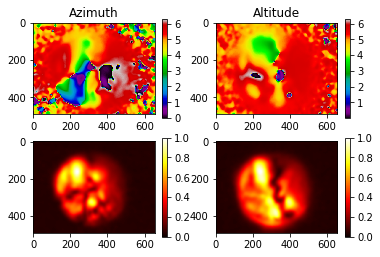

In [502]:

fig = plt.figure()

azi_map = mapdata['azimuth']['phase'].copy() #mapdata['azimuth'].copy()
alt_map = mapdata['altitude']['phase'].copy()
azi_pwr = mapdata['azimuth']['%s' % power_metric]/mapdata['azimuth']['%s' % power_metric].max()
alt_pwr = mapdata['altitude']['%s' % power_metric]/mapdata['altitude']['%s' % power_metric].max()

fig.add_subplot(221)
plt.imshow(azi_map, cmap='nipy_spectral', vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title('Azimuth')

fig.add_subplot(222)
plt.imshow(alt_map, cmap='nipy_spectral') #,  vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title('Altitude')


fig.add_subplot(223)
plt.imshow(azi_pwr, cmap='hot', vmin=0, vmax=1)
plt.colorbar()

fig.add_subplot(224)
plt.imshow(alt_pwr, cmap='hot',  vmin=0, vmax=1)
plt.colorbar()

#### Convert to linear (screen) range

In [504]:
screen_w, screen_h = (117, 67)
screen_w_deg = screen_w/2.
screen_h_deg = screen_h/2.

print(screen_w_deg, screen_h_deg)


(58.5, 33.5)


Old min/max: 0.00, 6.28
[AZI] New min/max: -58.50, 58.50
[ALT] New min/max: -58.50, 58.50
(-58.47534195388346, 58.47402905024029)


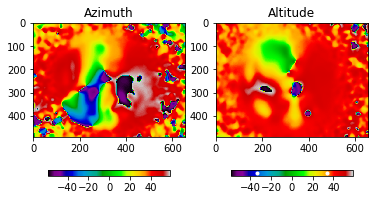

In [505]:
lmin_azi, lmax_azi = (-screen_w_deg, screen_w_deg)
lmin_alt, lmax_alt = (-screen_w_deg, screen_w_deg) #(-33.66, 33.66)
screen_h_min, screen_h_max = (-screen_h_deg, screen_h_deg)

print("Old min/max: %.2f, %.2f" % (vmin, vmax))
print("[AZI] New min/max: %.2f, %.2f" % (lmin_azi, lmax_azi))
print("[ALT] New min/max: %.2f, %.2f" % (lmin_alt, lmax_alt))


azi_lin = convert_range(azi_map, newmin=lmin_azi, newmax=lmax_azi, oldmin=vmin, oldmax=vmax)
alt_lin = convert_range(alt_map, newmin=lmin_alt, newmax=lmax_alt, oldmin=vmin, oldmax=vmax)

#phase_el_smooth = convert_range(phase_el_smooth, newmin=lmin_alt, newmax=lmax_alt, oldmin=vmin_el, oldmax=vmax_el)
#print("phase min/max: %.2f / %.2f" % (phase_az_smooth.min(), phase_az_smooth.max()))

print(azi_lin.min(), azi_lin.max())
fig = plt.figure()

fig.add_subplot(121)
plt.title('Azimuth')
plt.imshow(azi_lin, cmap='nipy_spectral', vmin=lmin_azi, vmax=lmax_azi)
plt.colorbar(orientation='horizontal', shrink=0.8)


fig.add_subplot(122)
plt.title('Altitude')
plt.imshow(alt_lin, cmap='nipy_spectral', vmin=lmin_alt, vmax=lmax_alt)
cb = plt.colorbar(orientation='horizontal', shrink=0.8)

screen_lim_pos = (lmax_alt-screen_h_max)/(lmax_alt*2.)
cb.ax.plot(screen_lim_pos, 0.5, 'w.') # my data is between 0 and 1
cb.ax.plot(1-screen_lim_pos, 0.5, 'w.') # my data is between 0 and 1

# cb.ax.axvline(x=screen_h_min, c='w')          # line at 3


## filter + smooth

In [506]:
mapdata['azimuth'].keys()

['phase', 'magRatio']

In [507]:
mag_az_raw.min()

0.004829881110491139

In [508]:
mapdata['azimuth'].keys()

['phase', 'magRatio']

In [509]:
smooth_fwhm = 5
mag_thr=0.03


phase_az_raw = mapdata['azimuth']['phase'].copy()
phase_el_raw = mapdata['altitude']['phase'].copy()
print(phase_el_raw.min(), phase_el_raw.max())

mag_az_raw = mapdata['azimuth'][power_metric].copy()
mag_el_raw = mapdata['altitude'][power_metric].copy()

phase_az_smooth = shift_map(smooth_array(phase_az_raw, smooth_fwhm, phaseArray=True))
phase_el_smooth = shift_map(smooth_array(phase_el_raw, smooth_fwhm, phaseArray=True))
print(phase_el_smooth.min(), phase_el_smooth.max())

# print("pre-smooth", azi_map.min(), azi_map.max())

# phase_az_smooth = shift_map(smooth_array(azi_map, smooth_fwhm, phaseArray=True))
# phase_el_smooth = shift_map(smooth_array(alt_map, smooth_fwhm, phaseArray=True))

# print("post-smooth", phase_az_smooth.min(), phase_az_smooth.max())

# phase_az_smooth = smooth_array(phase_az_raw, smooth_fwhm, phaseArray=True)
# phase_el_smooth = smooth_array(phase_el_raw, smooth_fwhm, phaseArray=True)

mag_az_smooth = smooth_array(mag_az_raw, smooth_fwhm, phaseArray=False)
mag_el_smooth = smooth_array(mag_el_raw, smooth_fwhm, phaseArray=False)

# THR by mag
phase_az_smooth[mag_az_smooth<mag_thr] = 0
phase_el_smooth[mag_az_smooth<mag_thr] = 0 

# normalize power
altitude_power_map_normed = mag_el_smooth/mag_el_smooth.max()
azimuth_power_map_normed = mag_az_smooth/mag_az_smooth.max()


(0.003641344613232308, 6.281814283659196)
(0.0016797672729654467, 6.282951174920063)


In [510]:
print("max pwr: %.4f" % mag_az_smooth.max())
print("phase min/max: %.2f / %.2f" % (phase_az_smooth.min(), phase_az_smooth.max()))
print("phase min/max: %.2f / %.2f" % (phase_el_smooth.min(), phase_el_smooth.max()))

max pwr: 0.1531
phase min/max: 0.00 / 6.28
phase min/max: 0.00 / 6.28


In [511]:
## Convert to degrees
in_degrees = True

if shift:
    vmin_az, vmax_az = 0, 2*np.pi
    vmin_el, vmax_el = 0, 2*np.pi
    print(vmin, vmax)
else:
    vmin_az, vmax_az = -np.pi, np.pi # (0, 120)
    vmin_el, vmax_el = -np.pi, np.pi # (-40, 60)

#vmin_az, vmax_az = (phase_az_smooth[~np.isnan(phase_az_smooth)].min(), phase_az_smooth[~np.isnan(phase_az_smooth)].max())
#vmin_el, vmax_el = (phase_el_smooth[~np.isnan(phase_el_smooth)].min(), phase_el_smooth[~np.isnan(phase_el_smooth)].max())

lmin_azi, lmax_azi = (-59.78, 59.78)
lmin_alt, lmax_alt = (-59.78, 59.78)# (-33.66, 33.66)

phase_az_smooth = convert_range(phase_az_smooth, newmin=lmin_azi, newmax=lmax_azi, oldmin=vmin_az, oldmax=vmax_az)
phase_el_smooth = convert_range(phase_el_smooth, newmin=lmin_alt, newmax=lmax_alt, oldmin=vmin_el, oldmax=vmax_el)

print("phase min/max: %.2f / %.2f" % (phase_az_smooth.min(), phase_az_smooth.max()))

# # THR by mag
phase_az_smooth[mag_az_smooth<mag_thr] = 0
phase_el_smooth[mag_az_smooth<mag_thr] = 0 
phase_el_smooth[mag_el_smooth<mag_thr] = 0 
phase_az_smooth[mag_el_smooth<mag_thr] = 0


(0, 6.283185307179586)
phase min/max: -59.78 / 59.77


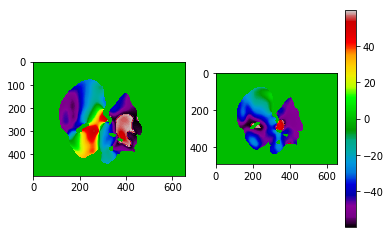

In [512]:
#plt.figure(1, 2)
f, axn = plt.subplots(1,2)

im = axn[0].imshow(phase_az_smooth, cmap='nipy_spectral', vmin=lmin_azi, vmax=lmax_azi)
f.colorbar(im) #.colorbar()
im = axn[1].imshow(phase_el_smooth, cmap='nipy_spectral', vmin=lmin_azi, vmax=lmax_azi)
#f.colorbar(im) #.colorbar()


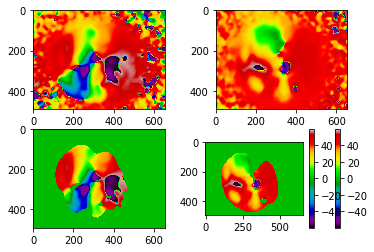

In [513]:
#plt.figure(1, 2)
f, axn = plt.subplots(2,2)

im = axn[0,0].imshow(azi_lin, cmap='nipy_spectral', vmin=lmin_azi, vmax=lmax_azi)
f.colorbar(im) #.colorbar()

im = axn[0,1].imshow(alt_lin, cmap='nipy_spectral', vmin=lmin_azi, vmax=lmax_azi)
#f.colorbar(im) #.colorbar()


# # THR by mag
magmap_az_nonnormalized = mapdata['azimuth']['%s' % power_metric].copy()
magmap_el_nonnormalized = mapdata['altitude']['%s' % power_metric].copy()

phase_az_smooth=azi_lin.copy()
phase_az_smooth[magmap_az_nonnormalized<mag_thr] = 0
phase_el_smooth = alt_lin.copy()
phase_el_smooth[magmap_el_nonnormalized<mag_thr] = 0 

im = axn[1,0].imshow(phase_az_smooth, cmap='nipy_spectral', vmin=lmin_azi, vmax=lmax_azi)
im = axn[1,1].imshow(phase_el_smooth, cmap='nipy_spectral', vmin=lmin_azi, vmax=lmax_azi)
f.colorbar(im) #.colorbar()


In [514]:
azi_pwr.min(), azi_pwr.max()

(0.03057889076329611, 1.0)

# Set output dir

In [515]:
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
base_dir = os.path.join(aggregate_dir, 'widefield-maps', 'signmaps')
dst_dir = os.path.join(base_dir, 'retinotopic-mapper', data_id)

print(dst_dir)
if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)


/n/coxfs01/julianarhee/aggregate-visual-areas/widefield-maps/signmaps/retinotopic-mapper/JC061_20190306


# Defining image analysis parameters  

#### This is probably the most important part of the whole analysis! The 14 parameters below define the final segmentation results.  
<br>
* phaseMapFilterSigma: The sigma value (in pixels) of Gaussian filter for altitude and azimuth maps. FLOAT, default = 1.0, recommended range: [0.0, 2.0]. Large "phaseMapFilterSigma" gives you more patches. Small "phaseMapFilterSigma" gives you less patches.
<br><br>
* signMapFilterSigma: The sigma value (in pixels) of Gaussian filter for visual sign maps. FLOAT, default = 9.0, recommended range: [0.6, 10.0]. Large "signMapFilterSigma" gives you less patches. Small "signMapFilterSigma" gives you more patches.
<br><br>
* signMapThr: Threshold to binarize visual signmap. FLOAT, default = 0.35, recommended range: [0.2, 0.5], allowed range: [0, 1). Large signMapThr gives you fewer patches. Smaller signMapThr gives you more patches.
<br><br>
* closeIter: Binary close iteration for each raw patches. INT, default = 3. You do not want to change this parameter very often.
<br><br>
* openIter: Binary open iteration for each raw patches. INT, default = 3. You do not want to change this parameter very often
<br><br>
* dilationIter: Binary dilation iteration for each raw patches. INT, default = 15. You do not want to change this parameter very often. 
<br><br>
* borderWidth: Pixel number between adjcent patches. INT, default = 1. You do not want to change this parameter very often.
<br><br>
* smallPatchThr: The patches with pixel number below smallPatchThr will be discarded. INT, default = 100. You do not want to change this parameter very often.
<br><br>
* eccMapFilterSigma: The sigma value of Gaussian filter for eccentricity maps. FLOAT, default = 10.0. You do not want to change this parameter very often.
<br><br>
* visualSpacePixelSize: The pixel size for patch to visual space mapping. FLOAT, default = 0.5. You do not want to change this parameter very often. 
<br><br>
* visualSpaceCloseIter: The binary iteration for visual space coverage for each patch. INT, default = 15. You do not want to change this parameter very often.
<br><br>
* splitLocalMinCutStep: The step width for detecting number of local minimums during spliting. The local minimums detected will be used as marker in the following open cv watershed segmentation. FLOAT, default = 5.0, recommend range: [0.5, 15.0]. Small "splitLocalMinCutStep" will make it more likely to split but into less sub patches. Large "splitLocalMinCutStep" will make it less likely to split but into more sub patches. 
<br><br>
* splitOverlapThr: Patches with overlap ration larger than this value will go through the split procedure. FLOAT, default = 1.1, recommend range: [1.0, 1.2], should be larger than 1.0. Small "splitOverlapThr" will split more patches. Large "splitOverlapThr" will split less patches. 
<br><br>
* mergeOverlapThr: Considering a patch pair (A and B) with same sign, A has visual coverage a deg<sup>2</sup> and B has visual coverage b deg<sup>2</sup> and the overlaping visual coverage between this pair is c deg<sup>2</sup>. Then if (c/a < "mergeOverlapThr") and (c/b < "mergeOverlapThr"), these two patches will be merged. FLOAT, default = 0.1, recommend range: [0.0, 0.2], should be smaller than 1.0. Small "mergeOverlapThr" will merge less patches. Large "mergeOverlapThr" will merge more patches.

In [516]:
reload(rm)
import json

In [517]:
print(dst_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/widefield-maps/signmaps/retinotopic-mapper/JC061_20190306


# Creating the RetinotopicMappingTrail object

In [549]:
mag_thr = 0.03
smooth_fwhm
params = {
          'phaseMapFilterSigma': 2, #None, # 0,
          'signMapFilterSigma': 9, #5.,
          'signMapThr': 0.2, #0.35, #0.5,
          'eccMapFilterSigma': 10.0, #5., #10.0,
          'splitLocalMinCutStep': 5., #10., #5.,
          'closeIter': 3,
          'openIter': 9,
          'dilationIter': 21,
          'borderWidth': 1,
          'smallPatchThr': 400, #100,
          'visualSpacePixelSize': 0.5, #0.5, #5,
          'visualSpaceCloseIter': 15,
          'splitOverlapThr': 1.1,
          'mergeOverlapThr': 0.1, #0.01,
          'lmin_alt': lmin_alt,
          'lmax_alt': lmax_alt, 
          'lmin_azi': lmin_azi,
          'lmax_azi': lmax_azi, 
          
          # preprocessing 
          'mag_thr': mag_thr,
          'smooth_fwhm': smooth_fwhm
          }


params_fpath = os.path.join(dst_dir, '%s_params.json' % data_id)
with open(params_fpath, 'w') as f:
    json.dump(params, f, indent=4, sort_keys=True)

In [550]:
# altitude_phase_map = shift_map(phase_el_raw.copy()) #phase_el_smooth.copy()
# azimuth_phase_map = shift_map(phase_az_raw.copy()) #phase_az_smooth.copy()
# azimuth_phase_map = convert_range(azimuth_phase_map, newmin=lmin_azi, newmax=lmax_azi, oldmin=vmin_az, oldmax=vmax_az)
# altitude_phase_map = convert_range(altitude_phase_map, newmin=lmin_alt, newmax=lmax_alt, oldmin=vmin_el, oldmax=vmax_el)

vmin_az = 0
vmax_az= 2*np.pi

#phase_az_smooth = convert_range(azi_map, newmin=lmin_azi, newmax=lmax_azi, oldmin=vmin_az, oldmax=vmax_az)
#phase_el_smooth = convert_range(alt_map, newmin=lmin_alt, newmax=lmax_alt, oldmin=vmin_az, oldmax=vmax_az)

filter_by_mag = True

altitude_phase_map = phase_el_smooth.copy() if filter_by_mag else alt_lin.copy()
azimuth_phase_map = phase_az_smooth.copy() if filter_by_mag else azi_lin.copy()

altitude_power_map = alt_pwr.copy()
azimuth_power_map = azi_pwr.copy()

# altitude_phase_map = phase_el_smooth.copy()
# azimuth_phase_map = phase_az_smooth.copy()

# altitude_power_map = mag_el_smooth.copy()
# azimuth_power_map = mag_az_smooth.copy()

In [551]:
print(azimuth_phase_map.min(), azimuth_phase_map.max())

(-58.47534195388346, 58.47402905024029)


In [552]:
print(lmin_azi, lmax_azi)
print(lmin_alt, lmax_alt)

(-59.78, 59.78)
(-59.78, 59.78)


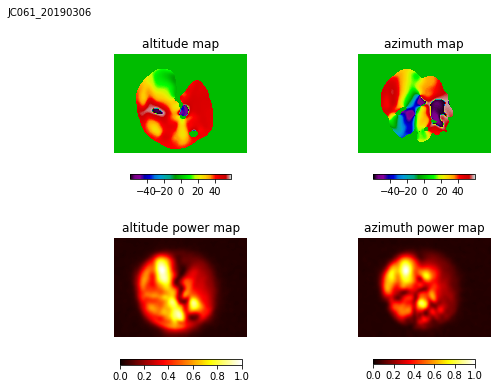

In [553]:
cmap = 'nipy_spectral'
in_degrees = True

f = plt.figure(figsize=(8, 6))
ax1 = f.add_subplot(221)
if in_degrees:
    vmin_az, vmax_az = (lmin_azi, lmax_azi)
    vmin_el, vmax_el = (lmin_azi, lmax_azi) #(lmin_alt, lmax_alt)
else:
    if shift:
        vmin_az, vmax_az = 0, 2*np.pi
        vmin_el, vmax_el = 0, 2*np.pi
    else:
        vmin_az, vmax_az = -np.pi, np.pi # (0, 120)
        vmin_el, vmax_el = -np.pi, np.pi # (-40, 60)

fig1 = ax1.imshow(altitude_phase_map, vmin=vmin_el, vmax=vmax_el, cmap=cmap, interpolation='nearest')
ax1.set_axis_off()
ax1.set_title('altitude map')
_ = f.colorbar(fig1, orientation='horizontal', shrink=0.5)

ax2 = f.add_subplot(222)
fig2 = ax2.imshow(azimuth_phase_map, vmin=vmin_az, vmax=vmax_az, cmap=cmap, interpolation='nearest')
ax2.set_axis_off()
ax2.set_title('azimuth map')
_ = f.colorbar(fig2, orientation='horizontal', shrink=0.5)

ax3 = f.add_subplot(223)
fig3 = ax3.imshow(altitude_power_map, vmin=0, vmax=1, cmap='hot', interpolation='nearest')
ax3.set_axis_off()
ax3.set_title('altitude power map')
_ = f.colorbar(fig3, orientation='horizontal', shrink=0.6)

ax4 = f.add_subplot(224)
fig4 = ax4.imshow(azimuth_power_map, vmin=0, vmax=1, cmap='hot', interpolation='nearest')
ax4.set_axis_off()
ax4.set_title('azimuth power map')
_ = f.colorbar(fig4, orientation='horizontal', shrink=0.5)

plt.subplots_adjust(hspace=0.3, wspace=0.2)

label_figure(f, data_id)
plt.savefig(os.path.join(dst_dir, '%s_input_maps.png' % data_id))

# Create trial object

In [554]:
import retinotopic_mapping.RetinotopicMapping as rm

reload(rm)

<module 'retinotopic_mapping.RetinotopicMapping' from '/home/julianarhee/anaconda2/envs/retinotopic_mapping/lib/python2.7/site-packages/retinotopic_mapping-2.9.4-py2.7.egg/retinotopic_mapping/RetinotopicMapping.pyc'>

In [555]:
filter_by_mag=True

# Create trial object
trial = rm.RetinotopicMappingTrial(altPosMap= phase_el_smooth.copy() if filter_by_mag else alt_lin.copy(),
                                   aziPosMap=phase_az_smooth.copy() if filter_by_mag else azi_lin.copy(),
                                   altPowerMap=alt_pwr, #altitude_power_map,
                                   aziPowerMap=azi_pwr, #azimuth_power_map,
                                   vasculatureMap=vasculature_map,
                                   mouseID=animalid,
                                   dateRecorded=session,
                                   comments='This is an example.',
                                   params=params)

# Generating visual sign map

In [556]:
print trial
print(alt_lin.shape)
print(trial.getName())


A retinotopic mapping trial: 20190306_MJC061
(492, 656)
20190306_MJC061


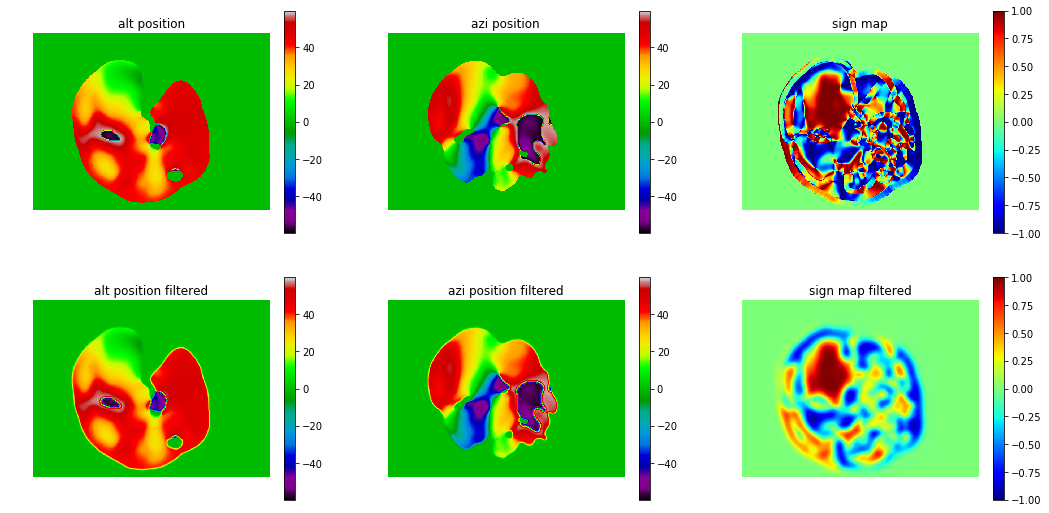

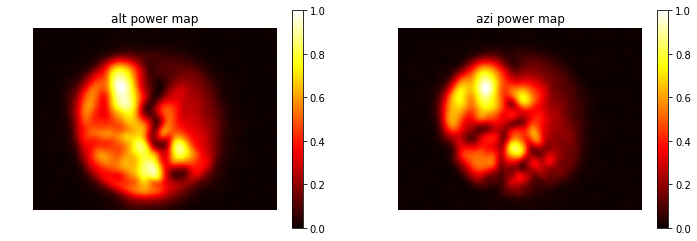

In [557]:
_ = trial._getSignMap(isPlot=True, isFixedRange=True, cmap='nipy_spectral')
# f1 = plot_getSignMap(trial, isFixedRange=True)

# label_figure(f1, data_id)
#plt.savefig(os.path.join(dst_dir, '%s_get_sign_map.png' % data_id))

In [558]:
trial.params['lmin_alt'], trial.params['lmax_alt']

(-59.78, 59.78)

patch05AU=1206.5 AS=1507.256188645559 ratio=1.2492798911276908
2 local minuma were found!!!
patch21AU=38.5 AS=63.09629803060144 ratio=1.6388648839117257
Only one local minumum was found!!!
patch20AU=1287.5 AS=4905.135143776023 ratio=3.8098137039037074
Only one local minumum was found!!!
patch09AU=426.0 AS=526.3415600468416 ratio=1.2355435681850742
Only one local minumum was found!!!
patch08AU=81.75 AS=533.1678730970267 ratio=6.521931169382589
Only one local minumum was found!!!
patch04AU=558.75 AS=1134.6666867638694 ratio=2.030723376758603
5 local minuma were found!!!
patch12AU=108.0 AS=340.49369990464015 ratio=3.152719443561483
Only one local minumum was found!!!
patch13AU=1454.0 AS=12322.734455307083 ratio=8.475058084805422
2 local minuma were found!!!
patch07AU=1542.75 AS=2379.9365821409483 ratio=1.542658617495348
4 local minuma were found!!!
patch11AU=572.25 AS=543.7368874840251 ratio=0.9501736784342947
patch16AU=236.5 AS=807.9721471581963 ratio=3.416372715256644
2 local minuma wer

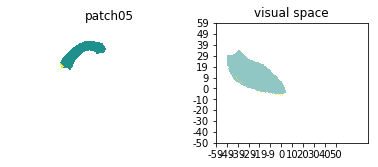

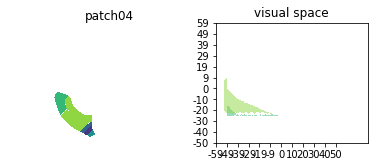

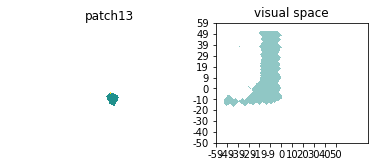

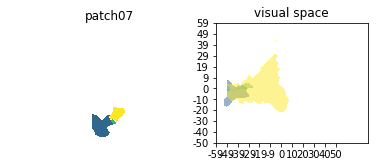

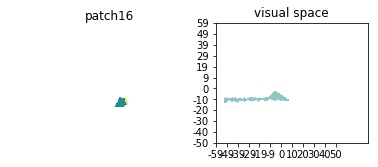

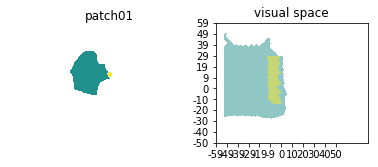

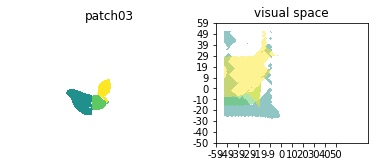

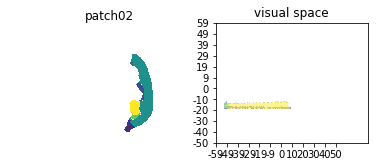

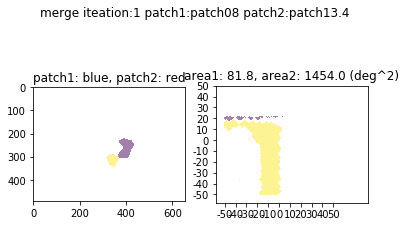

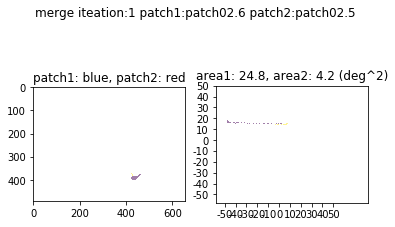

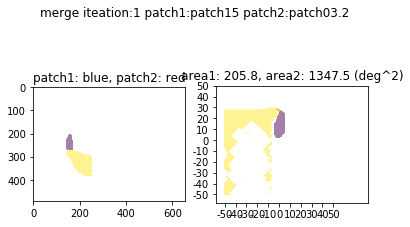

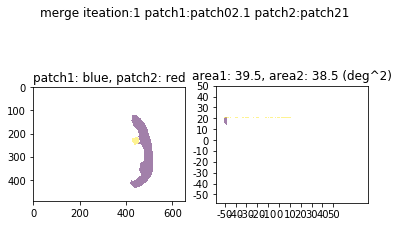

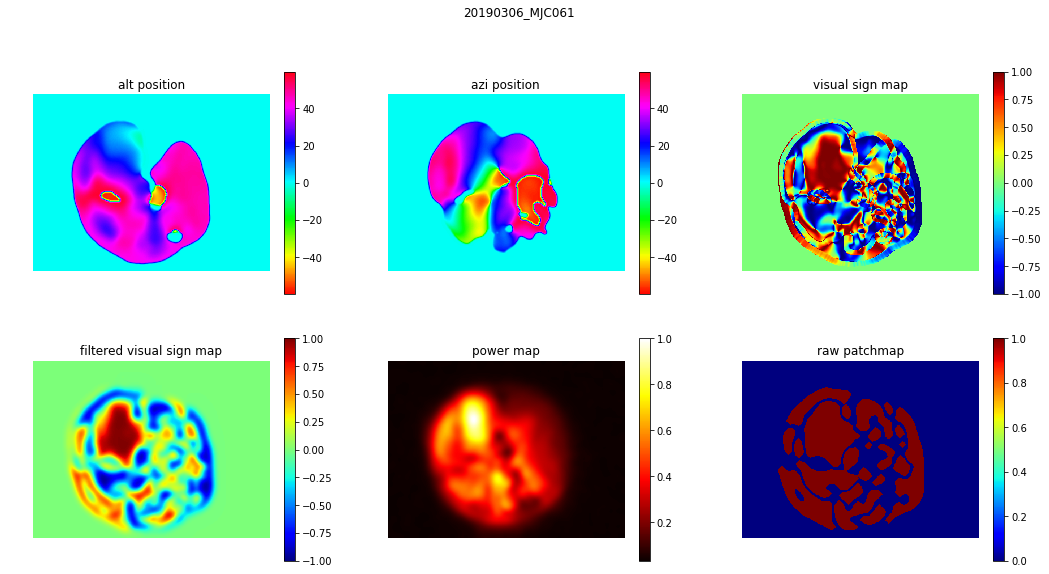

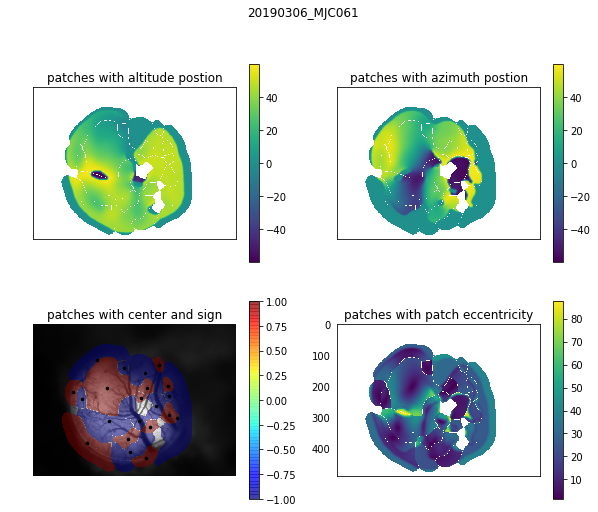

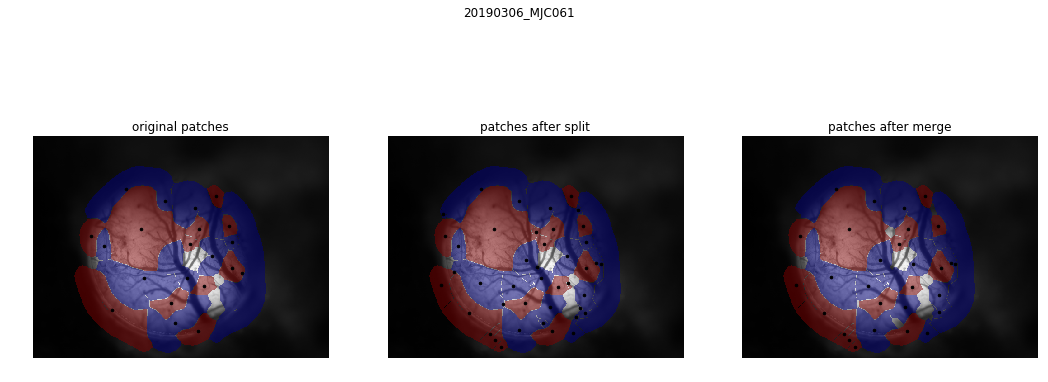

In [559]:
trial.plotTrial(isSave=True, saveFolder=dst_dir)

# Binarizing filtered visual signmap

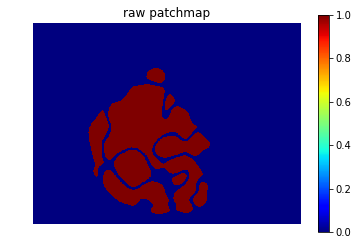

In [209]:
_ = trial._getRawPatchMap(isPlot=True)
plt.show()

# Generating raw patches

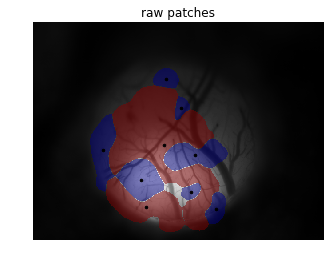

In [210]:
_ = trial._getRawPatches(isPlot=True)
plt.show()

# Generating determinant map

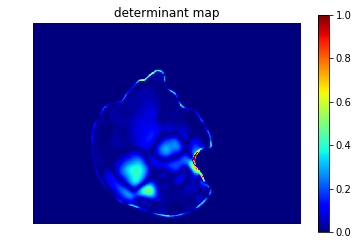

In [163]:
_ = trial._getDeterminantMap(isPlot=True, cmap='jet')
plt.show()

# Generating eccentricity map for each patch

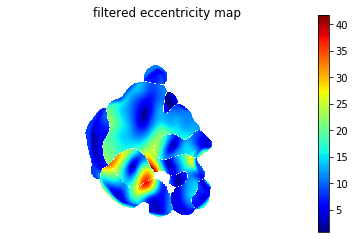

In [164]:
_ = trial._getEccentricityMap(isPlot=True)
plt.show()

# Splitting overlapping patches

patch09AU=22.0 AS=13.730538490242644 ratio=0.6241153859201202
patch08AU=65.75 AS=55.51121345181018 ratio=0.844277010673919
patch05AU=23.0 AS=122.225300004615 ratio=5.314143478461522
Only one local minumum was found!!!
patch04AU=712.25 AS=846.6054617333965 ratio=1.1886352569089456
2 local minuma were found!!!
patch07AU=120.0 AS=154.5782472977431 ratio=1.2881520608145258
Only one local minumum was found!!!
patch06AU=129.0 AS=160.6744108627516 ratio=1.245538068703501
Only one local minumum was found!!!
patch01AU=1103.25 AS=1977.021221856253 ratio=1.7919974818547502
7 local minuma were found!!!
patch03AU=1276.5 AS=1263.0524904100378 ratio=0.989465327387417
patch02AU=1056.0 AS=1125.5395812747063 ratio=1.0658518762071083


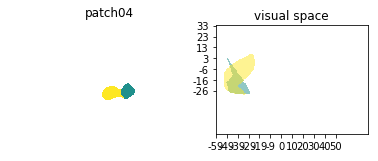

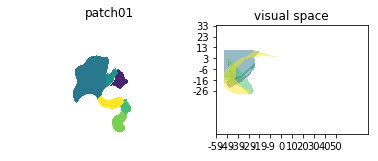

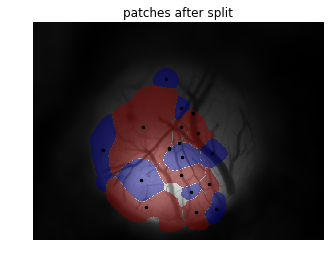

In [165]:
_ = trial._splitPatches(isPlot=True)
plt.show()

# Merging non-overlapping patches

merge iteration: 1


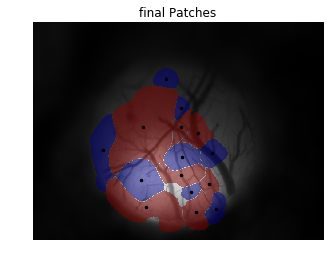

In [166]:
_ = trial._mergePatches(isPlot=True)
plt.show()

## Note:  
### The methods used from cell 8 to cell 14 are protected by leading underscore! Here they were used separately to show every single image analysis step. In real life, the steps from cell 8 to cell 14 can be consolidated into one single method:  

`trial.processTrial(isPlot=True)`

# Plotting results

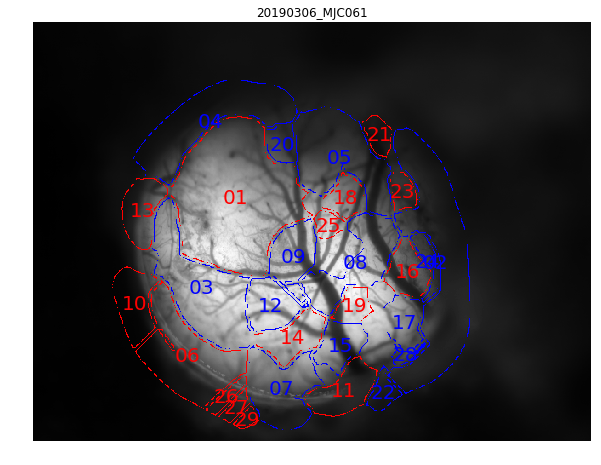

In [560]:
f = trial.plotFinalPatchBorders(borderWidth=2, fontSize=20)

#plt.show()

plt.savefig(os.path.join(dst_dir, '%s_final_patch_borders_fullres.png' % trial.getName()))
plt.show()


# Annotating segmented patches

In [562]:
# names = [
#          ['patch01', 'Lm'],
#          ['patch03', 'PL'],
#          ['patch07', 'LI'],
#          ['patch06', 'LL']
#          ]

names = [
         ['patch01', 'LM'],
         ['patch09', 'LI'],
         ['patch12', 'LIb'],
         ['patch19', 'LL'],
         ['patch03', 'PL']
         ]

finalPatchesMarked = dict(trial.finalPatches)

for i, namePair in enumerate(names):
    currPatch = finalPatchesMarked.pop(namePair[0])
    newPatchDict = {namePair[1]:currPatch}
    finalPatchesMarked.update(newPatchDict)
    
trial.finalPatchesMarked = finalPatchesMarked

# Ploting final results

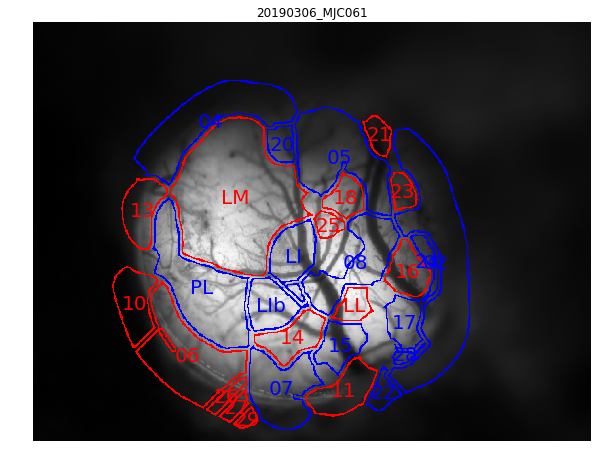

In [563]:
_ = trial.plotFinalPatchBorders(borderWidth=3, fontSize=20)

plt.savefig(os.path.join(dst_dir, '%s_final_patch_borders_labeled_fullres.png' % trial.getName()))

plt.show()

In [564]:
reload(rm)

<module 'retinotopic_mapping.RetinotopicMapping' from '/home/julianarhee/anaconda2/envs/retinotopic_mapping/lib/python2.7/site-packages/retinotopic_mapping-2.9.4-py2.7.egg/retinotopic_mapping/RetinotopicMapping.pyc'>

Can not find necessary visual areas (V1, LM, RL) for normalization. 
Setting origins to 0 ...
/n/coxfs01/julianarhee/aggregate-visual-areas/widefield-maps/signmaps/retinotopic-mapper/JC061_20190306


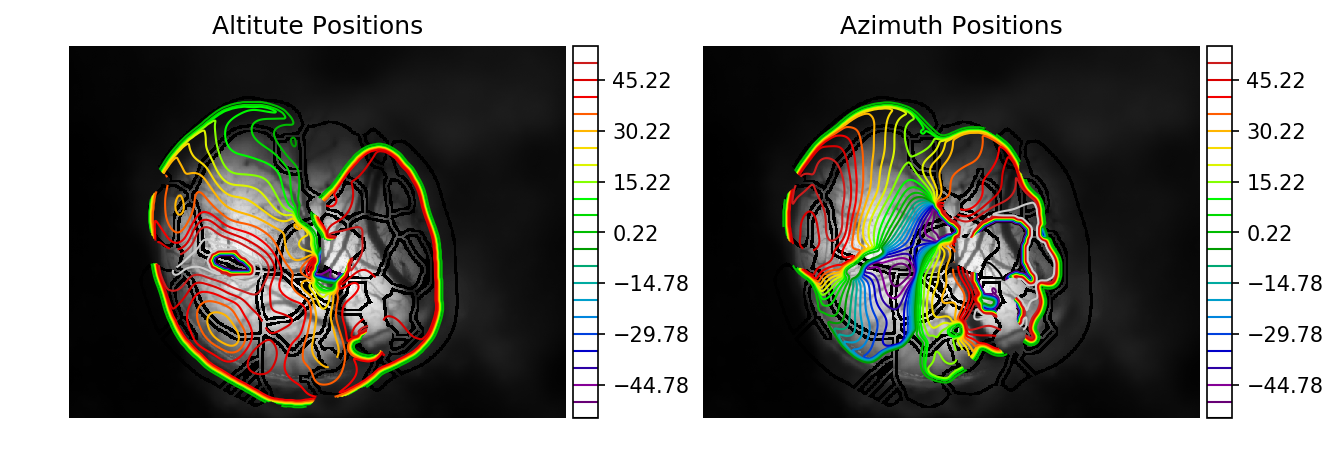

In [565]:
fig, axn = plt.subplots(1,2, dpi=150, figsize=(10,5))

contour_alt, contour_azi = trial.plotContours(cmap='nipy_spectral', inline=False, 
                                              altAxis=axn[0], aziAxis=axn[1], lineWidth=1, borderWidth=5)

# contour_alt.imshow(azi_msk, cmap='gray')

plt.savefig(os.path.join(dst_dir, '%s_final_contourplots.png' % trial.getName()))
print(dst_dir)

TypeError: imshow() takes at least 2 arguments (1 given)

<Figure size 432x288 with 0 Axes>

# Generating dictionary for saving

In [ ]:
trialDict = trial.generateTrialDict()
trialDict.keys()

# Saving results

In [576]:
results_fpath = os.path.join(dst_dir, '%s_results_fullres.pkl' % trial.getName())
ft.saveFile(results_fpath, trialDict)
print("saved results: ", results_fpath)

('saved results: ', '/n/coxfs01/julianarhee/aggregate-visual-areas/widefield-maps/signmaps/retinotopic-mapper/JC113_20191011/20191011_MJC113_results_fullres.pkl')


In [577]:
results_fpath

'/n/coxfs01/julianarhee/aggregate-visual-areas/widefield-maps/signmaps/retinotopic-mapper/JC113_20191011/20191011_MJC113_results_fullres.pkl'

In [252]:
class struct():
    pass

## Load 2p fov

In [254]:
import cPickle as pkl

In [255]:
rootdir = '/n/coxfs01/2p-data'
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'

coreg_dir = os.path.join(rootdir, animalid, 'coreg')
coreg_dfile = os.path.join(coreg_dir, 'alignment_results.pkl')

with open(coreg_dfile, 'rb') as f:
    coreg = pkl.load(f)
    


In [578]:
trial.aziPosMap.shape

(492, 656)

In [579]:
warped_rois = coreg['rois'].warped.astype(np.uint8)
roi_d1, roi_d2, nrois = warped_rois.shape
roi_img = warped_rois.sum(axis=-1).astype(np.uint8)

warped_fov2p = coreg['zproj'].warped.copy()


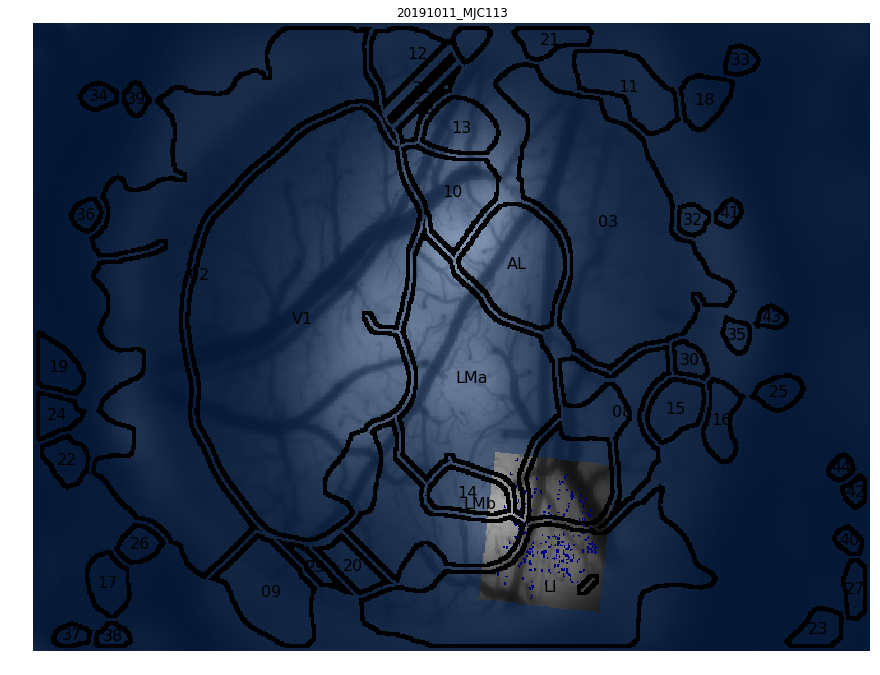

In [771]:

roi_img_overlay = roi_img.astype(bool).copy().astype(float)
roi_img_overlay[roi_img==0] = np.nan
fov2p_overlay = np.ma.masked_array(warped_fov2p==0, warped_fov2p)
# fov2p_overlay = fov2p_r.copy().astype(float)
# fov2p_overlay[fov2p_r==0] = np.nan

fig, ax = plt.subplots(figsize=(15,15))
fig.axes[0].imshow(vasculature_map, cmap='gray')
fig.axes[0].imshow(fov2p_overlay, alpha=.5, cmap='Blues_r')
fig.axes[0].imshow(roi_img_overlay, alpha=1, cmap='jet')


fig = trial.plotFinalPatchBorders(plotAxis=ax, isColor=False, plotVasMap=False, borderWidth=4 )
#fig.axes[0].axis('on')


In [608]:
patches = {}
for area_label, area_patch in trial.finalPatchesMarked.items():
    if 'patch' in area_label:
        continue
    patches.update({area_label: area_patch})

In [660]:
def label_patch(patch, key, plotAxis=None, plotColor='w', fontSize=16, zoom=1):
    #if plotName:
    
    if plotAxis is None:
        fig, plotAxis = pl.subplots()
    center = patch.getCenter()
    abbrev_key = key.split('patch')[-1]
    plotAxis.text(center[1] * zoom, center[0] * zoom, abbrev_key, verticalalignment='center',
                  horizontalalignment='center', color=plotColor, fontsize=fontSize)

    return plotAxis
                

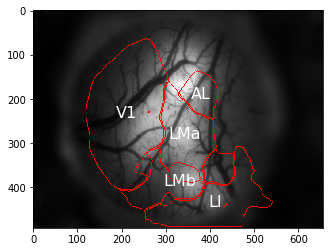

In [663]:
# pmask = currpatch.getMask()
# tmask = testpatch.getMask()


fig, ax = plt.subplots()
ax.imshow(vasculature_map, cmap='gray')


for vlabel, vpatch in patches.items():
    curr_patch_border = vpatch.getBorder()
    # plt.imshow(vpatch.getMask())
    pt.plot_mask(curr_patch_border, plotAxis=ax, borderWidth=2, closingIteration=None)
    
    label_patch(vpatch, vlabel, plotAxis=ax, plotColor='w')
    

In [630]:
curr_visual_area = 'LI'
curr_patch = trial.finalPatchesMarked[curr_area]

('patch range:', 0.0, 1.0)


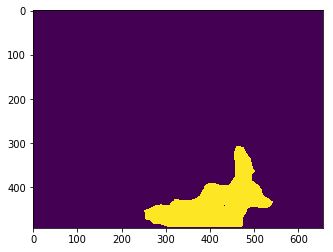

In [634]:
curr_patch_mask = curr_patch.getMask().copy()
curr_patch_mask[np.isnan(curr_patch.getMask())] = 0

plt.figure()
plt.imshow(curr_patch_mask)
print("patch range:", curr_patch_mask.min(), curr_patch_mask.max())

In [769]:
[r for r in np.arange(0, nrois) if not warped_rois[:,:,r].max() > 0]

[]

In [639]:
bool_rois = warped_rois.astype(bool).astype(int)
print(bool_rois.shape)
included_rois = np.array([ri for ri in np.arange(0, nrois) if ((bool_rois[:, :, ri] + curr_patch_mask) > 1).any()])
print("%i of %i ROIs included in area %s" % (len(included_rois), nrois, curr_visual_area))
      

(492, 656, 210)
124 of 210 ROIs included in area LI


In [676]:
included_rois_masks = bool_rois[:, :, included_rois].copy()
included_rois_masks.shape

included_rois_all = included_rois_masks.sum(axis=-1)
included_rois_overlay = included_rois_all.astype(float)
included_rois_overlay[included_rois_all==0] = np.nan

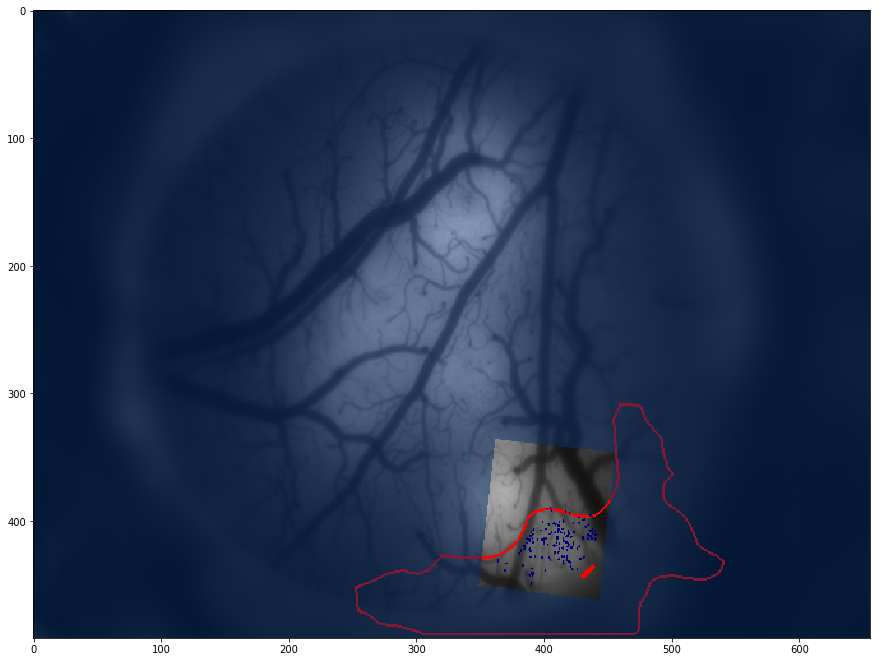

In [679]:
curr_patch_border = curr_patch.getBorder()
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(vasculature_map, cmap='gray')
pt.plot_mask(curr_patch_border, plotAxis=ax, borderWidth=2, closingIteration=2)
ax.imshow(fov2p_overlay, alpha=.5, cmap='Blues_r')
ax.imshow(included_rois_overlay, alpha=1, cmap='jet')


In [680]:
included_rois

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  32,  33,  51,  52,  53,  54,  55,  56,  57,
        58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,
        71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
        84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,
        97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109,
       110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122,
       123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135,
       136, 137, 162, 164, 187, 188, 189])

In [681]:
animalid

'JC113'

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

In [580]:
def get_roi_centroid(roi_mask):

    ret,thresh = cv2.threshold(roi_mask,127,255,0)
    M = cv2.moments(thresh)
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
    #M.keys()
    
    return (cX, cY)


def remap_scaled_point(orig_point, resize_factor=(0.33, 0.33)):
    orig_point = list(orig_point)
    scaled_point = (round(orig_point[0]*resize_factor[0]), round(orig_point[1]*resize_factor[1]))
                    
    return scaled_point

In [581]:
# target_d1, target_d2 = trial.vasculatureMap.shape
# print(target_d1, target_d2)
# masks_d1, masks_d2 = roi_img.shape

# ds_factor = int(round(float(masks_d1)/target_d1))
# print(ds_factor)

# ctrs = [get_roi_centroid(warped_rois[:, :, ri]) for ri in np.arange(0, nrois)]
# cX = [c[0] for c in ctrs]
# cY = [c[1] for c in ctrs]

(492, 656)
1


In [584]:
# target_d1, target_d2 = trial.vasculatureMap.shape
# print(target_d1, target_d2)
# masks_d1, masks_d2 = roi_img.shape

# ds_factor = int(round(float(masks_d1)/target_d1))
# print(ds_factor)
# resize_d1 = float(target_d1)/masks_d1
# resize_d2 = float(target_d2)/masks_d2


# if masks_d1 != masks_d2:
#     #rois_r = np.dstack([cv2.resize(warped_rois[:,:,ri], (target_d2, target_d1)) for ri in np.arange(0, nrois)])
#     #fov2p_r = cv2.resize(warped_fov2p.astype(np.uint8), (target_d2, target_d1), interpolation=cv2.INTER_NEAREST)
#     fov2p_r = cv2.resize(warped_fov2p.astype(np.uint8), (target_d2, target_d1),  fx=resize_d1, fy=resize_d2)
#     print(fov2p_r.shape)
#     roi_img_r = cv2.resize(roi_img.astype(np.uint8), (target_d2, target_d1),  fx=resize_d1, fy=resize_d2)
    
# ctrs_scaled = [remap_scaled_point(cpoint, resize_factor=(resize_d1, resize_d2)) for cpoint in ctrs]
    

In [585]:
# fig, axn = plt.subplots(1, 2, figsize=(30,15)) #plt.figure()

# ax = axn[0]
# ax.imshow(warped_fov2p, cmap='gray', origin='bottom')
# roi_img_o = roi_img.copy().astype(bool).astype(float)
# roi_img_o[roi_img==0]=np.nan
# ax.imshow(roi_img_o, cmap='Blues_r', alpha=1)
# ax.scatter(cX, cY, s=10, c='r')

# ax.set_xlim([300, 500])
# ax.set_ylim([300, masks_d1])
# #ax.invert_yaxis()


# ax = axn[1]
# ax.imshow(fov2p_r, cmap='gray', origin='bottom')
# roi_img_o = roi_img_r.copy().astype(bool).astype(float)
# roi_img_o[roi_img_r==0]=np.nan
# ax.imshow(roi_img_o, cmap='Blues_r', alpha=1)
# cx_r = [c[0] for c in ctrs_scaled]
# cy_r = [c[1] for c in ctrs_scaled]

# ax.scatter(cx_r, cy_r, s=10, c='r')

# ax.set_xlim([325*resize_d1, 460*resize_d1])
# ax.set_ylim([325*resize_d2, 460*resize_d2])


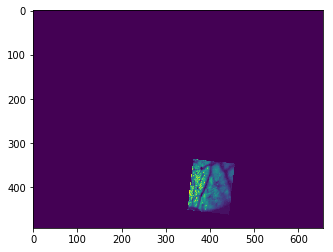

In [586]:
plt.figure()
plt.imshow(warped_fov2p)


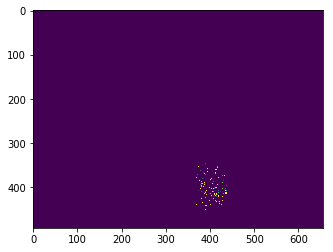

In [587]:
plt.figure()
plt.imshow(roi_img)